## Diffusion Models:

**Inspired from the previous year Deeplense participant  Super_Resolution model  that is Iterative Auto Encoder.ipynb by Atal Gupta**


In [1]:
import os
import math
import numpy as np
import pandas as pd 
import torch
from torch.utils.data import Dataset
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from matplotlib.colors import LinearSegmentedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array): High-resolution images of shape (N, 1, 128, 128).
        - lr_images (numpy array): Low-resolution images of shape (N, 1, 64, 64).
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)
    def __getitem__(self, idx):
        # Get your images
        lr = self.lr_images[idx]  
        hr = self.hr_images[idx]
    
        # Convert to tensors if needed
        if not isinstance(lr, torch.Tensor):
            lr = torch.tensor(lr, dtype=torch.float32)
        if not isinstance(hr, torch.Tensor):
            hr = torch.tensor(hr, dtype=torch.float32)
    
        lr = lr.unsqueeze(0) 
        hr = hr.unsqueeze(0)  
    
    # Interpolate - no need for additional unsqueeze(0) here
        lr_interpolated = F.interpolate(lr.unsqueeze(0), 
                                       size=(150, 150),
                                       mode='bilinear', 
                                       align_corners=False)
        lr_interpolated = lr_interpolated.squeeze(0)
    
        return lr_interpolated, hr
        
    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [3]:
lr_folder = "/kaggle/input/deeplense-dataset/Dataset/LR"
hr_folder = "/kaggle/input/deeplense-dataset/Dataset/HR"

In [4]:

def load_and_preprocess_data(lr_folder, hr_folder):
    """
    Args:
        lr_folder: Path to folder containing low-resolution image .npy files
        hr_folder: Path to folder containing high-resolution image .npy files
        test_size: Proportion of data for testing
    
    Returns:
        Normalized data splits
    """
    print("Loading data from folders...")
 
    lr_images_list = []
    hr_images_list = []
    for filename in os.listdir(lr_folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(lr_folder, filename)
            images = np.load(file_path)
            lr_images_list.append(images)
    
    for filename in os.listdir(hr_folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(hr_folder, filename)
            images = np.load(file_path)
            hr_images_list.append(images)
    
    lr_images = np.concatenate(lr_images_list, axis=0)
    hr_images = np.concatenate(hr_images_list, axis=0)
    
    print(f"Loaded {len(lr_images)} low-resolution images")
    print(f"Loaded {len(hr_images)} high-resolution images")
    
    print(f"LR Image Shape: {lr_images[0].shape}")
    print(f"HR Image Shape: {hr_images[0].shape}")
    
    lr_images = lr_images.astype(np.float32)
    hr_images = hr_images.astype(np.float32)

    return lr_images, hr_images
    
lr_images, hr_images = load_and_preprocess_data(lr_folder, hr_folder)

Loading data from folders...
Loaded 10000 low-resolution images
Loaded 10000 high-resolution images
LR Image Shape: (75, 75)
HR Image Shape: (150, 150)


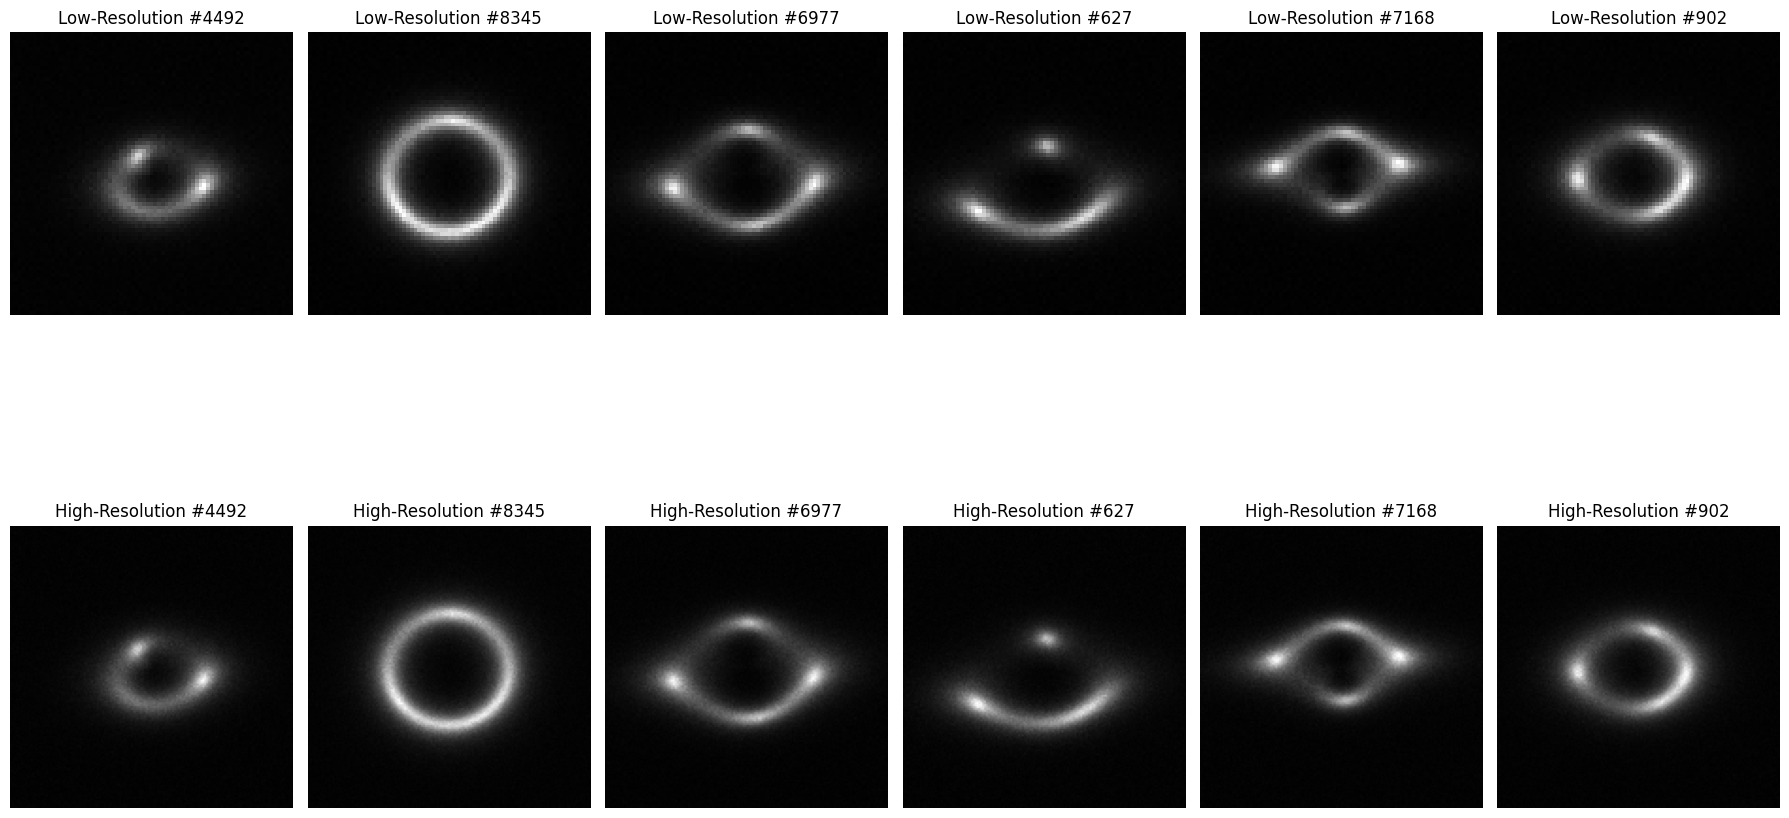

In [5]:
def visualize_samples(hr_images, lr_images, n_samples=5):
    """
    Visualize sample pairs of high-resolution and low-resolution images horizontally.
    
    Args:
        hr_images: High-resolution images
        lr_images: Low-resolution images
        n_samples: Number of sample pairs to visualize
    """
    # Select random samples
    indices = np.random.choice(len(hr_images), n_samples, replace=False)
    
    # Create a figure with n_samples rows and 2 columns
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 12))
    
    for i, idx in enumerate(indices):
        # Plot low-resolution image
        axes[0, i].imshow(lr_images[idx].squeeze(), cmap='gray')
        axes[0, i].set_title(f"Low-Resolution #{idx}")
        axes[0, i].axis('off')
        
        # Plot high-resolution image
        axes[1, i].imshow(hr_images[idx].squeeze(), cmap='gray')
        axes[1, i].set_title(f"High-Resolution #{idx}")
        axes[1, i].axis('off')
        
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

visualize_samples(hr_images, lr_images, n_samples=6)

In [6]:
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
def check_for_nans(data_loader):
    for batch_idx, (lr, hr) in enumerate(data_loader):
        if torch.isnan(lr).any():
            print(f"NaN values found in LR images in batch {batch_idx}")
        if torch.isnan(hr).any():
            print(f"NaN values found in HR images in batch {batch_idx}")

check_for_nans(train_loader)

In [10]:
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = 1000
betas = linear_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(hr, lr, t, device="cpu"):
    residual = hr - lr
    noise = torch.randn_like(residual)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, residual.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, residual.shape)
    
    noisy_residual = sqrt_alphas_cumprod_t.to(device) * residual.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    
    return noisy_residual, noise.to(device)

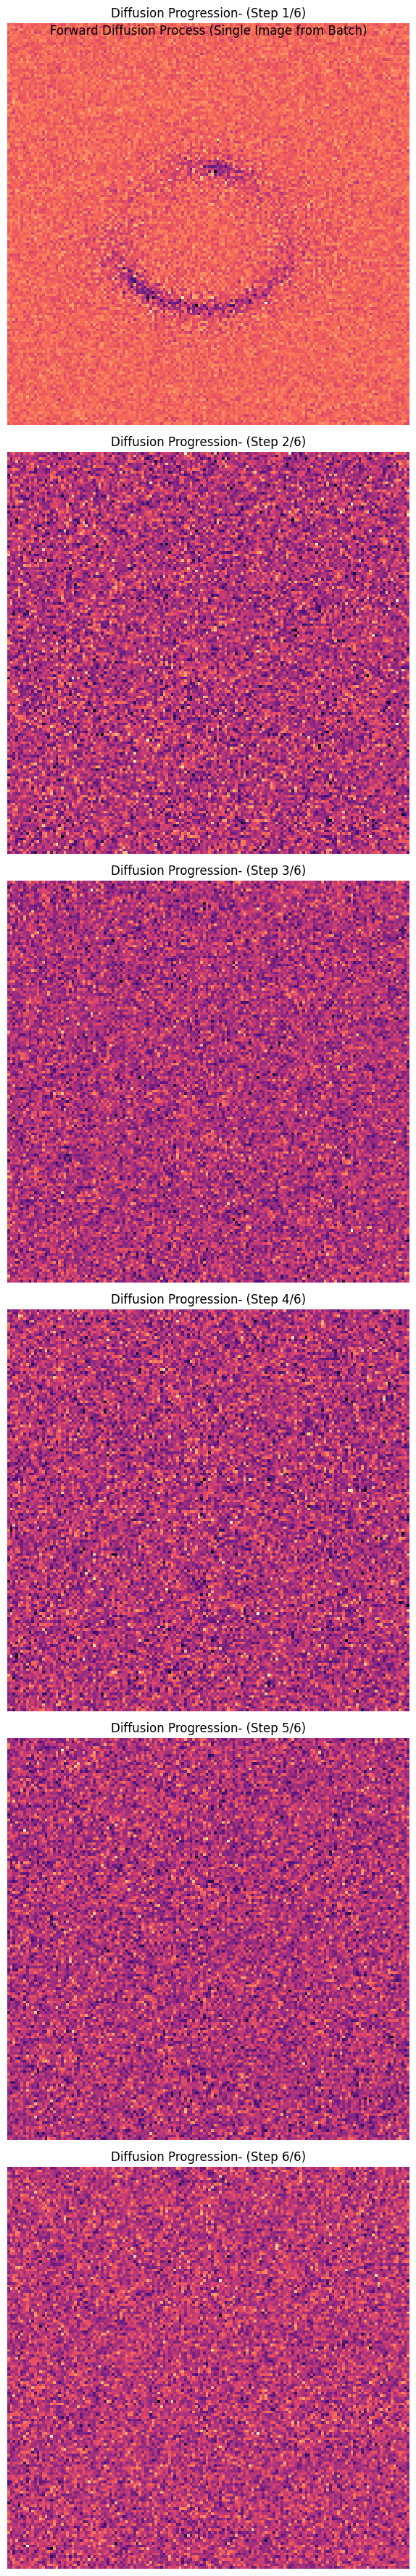

Forward diffusion process completed and visualized for a single image from the batch.


In [11]:

hr, lr = next(iter(train_loader))

image_index = 0  
steps = 6
fig, axs = plt.subplots(steps,1, figsize=(18, 6*steps))
fig.suptitle("Forward Diffusion Process (Single Image from Batch)")

for i in range(steps):
    t = torch.tensor([i * T // steps]).repeat(hr.size(0))
    noisy_residual, _ = forward_diffusion_sample(hr, lr, t)
    noisy_hr = noisy_residual
    lr_img = lr[image_index].squeeze().cpu().numpy()
    hr_img = hr[image_index].squeeze().cpu().numpy()
    noisy_hr_img = noisy_hr[image_index].squeeze().cpu().numpy()
    
    axs[i].imshow(noisy_hr_img, cmap='magma')
    axs[i].set_title(f'Diffusion Progression- (Step {i+1}/6)')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

print("Forward diffusion process completed and visualized for a single image from the batch.")

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## MODEL

In [13]:

class Block(nn.Module):
    
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1, output_padding=1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 2
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
       

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
    
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            if residual_x.shape[-1] != x.shape[-1]:
                residual_x = F.interpolate(residual_x, size=(x.shape[-2], x.shape[-1]), mode="bilinear", align_corners=False)
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        x = self.output(x)
        x = F.interpolate(x, size=(150, 150), mode="bilinear", align_corners=False)  
    
        return x


In [14]:
model = SimpleUnet().to(device)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, device, epochs=20, T=1000, lr=1e-5):
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    epoch_losses = []
    best_loss = float('inf')
    best_weights = None
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
            for step, (lr_img, hr_img) in enumerate(train_loader):
                lr_img, hr_img = lr_img.to(device), hr_img.to(device)
                
                optimizer.zero_grad()
                
                timesteps = torch.randint(0, T, (lr_img.size(0),), device=device).long()
                noisy_residual, noise = forward_diffusion_sample(hr_img, lr_img, timesteps, device)
                
                model_input = torch.cat([lr_img, noisy_residual], dim=1)
                
                predicted_residual = model(model_input, timesteps)
                predicted_hr = lr_img + predicted_residual
                
                loss = nn.L1Loss()(predicted_hr, hr_img)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
                pbar.update(1)
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        print(f"End of Epoch {epoch+1} | Avg Loss: {avg_epoch_loss:.8f}")
        
        # Save the best weights
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            best_weights = model.state_dict()
            print(f"New best loss: {best_loss:.8f}")
    
    # Load the best weights back into the model
    model.load_state_dict(best_weights)
    print("Training complete.")
    return epoch_losses

In [16]:
losses = train_model(model, train_loader, device, epochs=10, lr=1e-5)

Epoch 1/10: 100%|██████████| 1125/1125 [03:35<00:00,  5.23batch/s, loss=0.00656]


End of Epoch 1 | Avg Loss: 0.02980247
New best loss: 0.02980247


Epoch 2/10: 100%|██████████| 1125/1125 [03:33<00:00,  5.26batch/s, loss=0.00576]


End of Epoch 2 | Avg Loss: 0.00603339
New best loss: 0.00603339


Epoch 3/10: 100%|██████████| 1125/1125 [03:34<00:00,  5.26batch/s, loss=0.00547]


End of Epoch 3 | Avg Loss: 0.00548187
New best loss: 0.00548187


Epoch 4/10: 100%|██████████| 1125/1125 [03:33<00:00,  5.27batch/s, loss=0.00521]


End of Epoch 4 | Avg Loss: 0.00532188
New best loss: 0.00532188


Epoch 5/10: 100%|██████████| 1125/1125 [03:33<00:00,  5.28batch/s, loss=0.00522]


End of Epoch 5 | Avg Loss: 0.00524001
New best loss: 0.00524001


Epoch 6/10: 100%|██████████| 1125/1125 [03:32<00:00,  5.29batch/s, loss=0.00532]


End of Epoch 6 | Avg Loss: 0.00519026
New best loss: 0.00519026


Epoch 7/10: 100%|██████████| 1125/1125 [03:32<00:00,  5.29batch/s, loss=0.00513]


End of Epoch 7 | Avg Loss: 0.00516589
New best loss: 0.00516589


Epoch 8/10: 100%|██████████| 1125/1125 [03:32<00:00,  5.30batch/s, loss=0.00524]


End of Epoch 8 | Avg Loss: 0.00514612
New best loss: 0.00514612


Epoch 9/10: 100%|██████████| 1125/1125 [03:32<00:00,  5.29batch/s, loss=0.00511]


End of Epoch 9 | Avg Loss: 0.00513076
New best loss: 0.00513076


Epoch 10/10: 100%|██████████| 1125/1125 [03:32<00:00,  5.29batch/s, loss=0.00507]

End of Epoch 10 | Avg Loss: 0.00512113
New best loss: 0.00512113
Training complete.


In [17]:
save_path = "/kaggle/working/Diffusion_Model.pth"
torch.save(model.state_dict(), save_path)
print("Saved Successfully")


Saved Successfully


In [18]:
import torch
import numpy as np
from torch import nn
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_ssim(img1, img2, data_range=1.0, win_size=11):
    img1 = img1.squeeze().cpu().numpy()
    img2 = img2.squeeze().cpu().numpy()
    return structural_similarity(img1, img2, win_size=win_size, data_range=data_range, multichannel=False)

def evaluate_model(model, dataloader, device, win_size=11, data_range=1.0):
    model.eval()
    mse_hr_predhr = 0.0
    psnr_hr_predhr = 0.0
    ssim_hr_predhr = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for lr_batch, hr_batch in tqdm(dataloader, desc="Evaluating"):
            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
            batch_size = lr_batch.size(0)
            
            for i in range(batch_size):
                lr, hr = lr_batch[i].unsqueeze(0), hr_batch[i].unsqueeze(0)
                
                # Generate random noisy residual
                random_residual = torch.randn_like(lr)
                
                # Concatenate LR and random residual
                model_input = torch.cat([lr, random_residual], dim=1)
                
                # Set timestep to 1000 for starting from random noise
                timesteps = torch.tensor([1000], device=device).long()
                
                predicted_residual = model(model_input, timesteps)
                predicted_hr = lr + predicted_residual
                
                mse_hr_predhr += nn.MSELoss()(hr, predicted_hr).item()
                psnr_hr_predhr += calculate_psnr(hr, predicted_hr).item()
                ssim_hr_predhr += calculate_ssim(hr, predicted_hr, data_range, win_size)
                
                num_samples += 1
    
    mse_hr_predhr /= num_samples
    psnr_hr_predhr /= num_samples
    ssim_hr_predhr /= num_samples
    
    print(f"Average PSNR: {psnr_hr_predhr:.8f}")
    print(f"Average SSIM: {ssim_hr_predhr:.8f}")
    print(f"Average MSE: {mse_hr_predhr:.8f}")

evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 125/125 [00:15<00:00,  8.23it/s]

Average PSNR: 41.78976270
Average SSIM: 0.97712056
Average MSE: 0.00006671


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

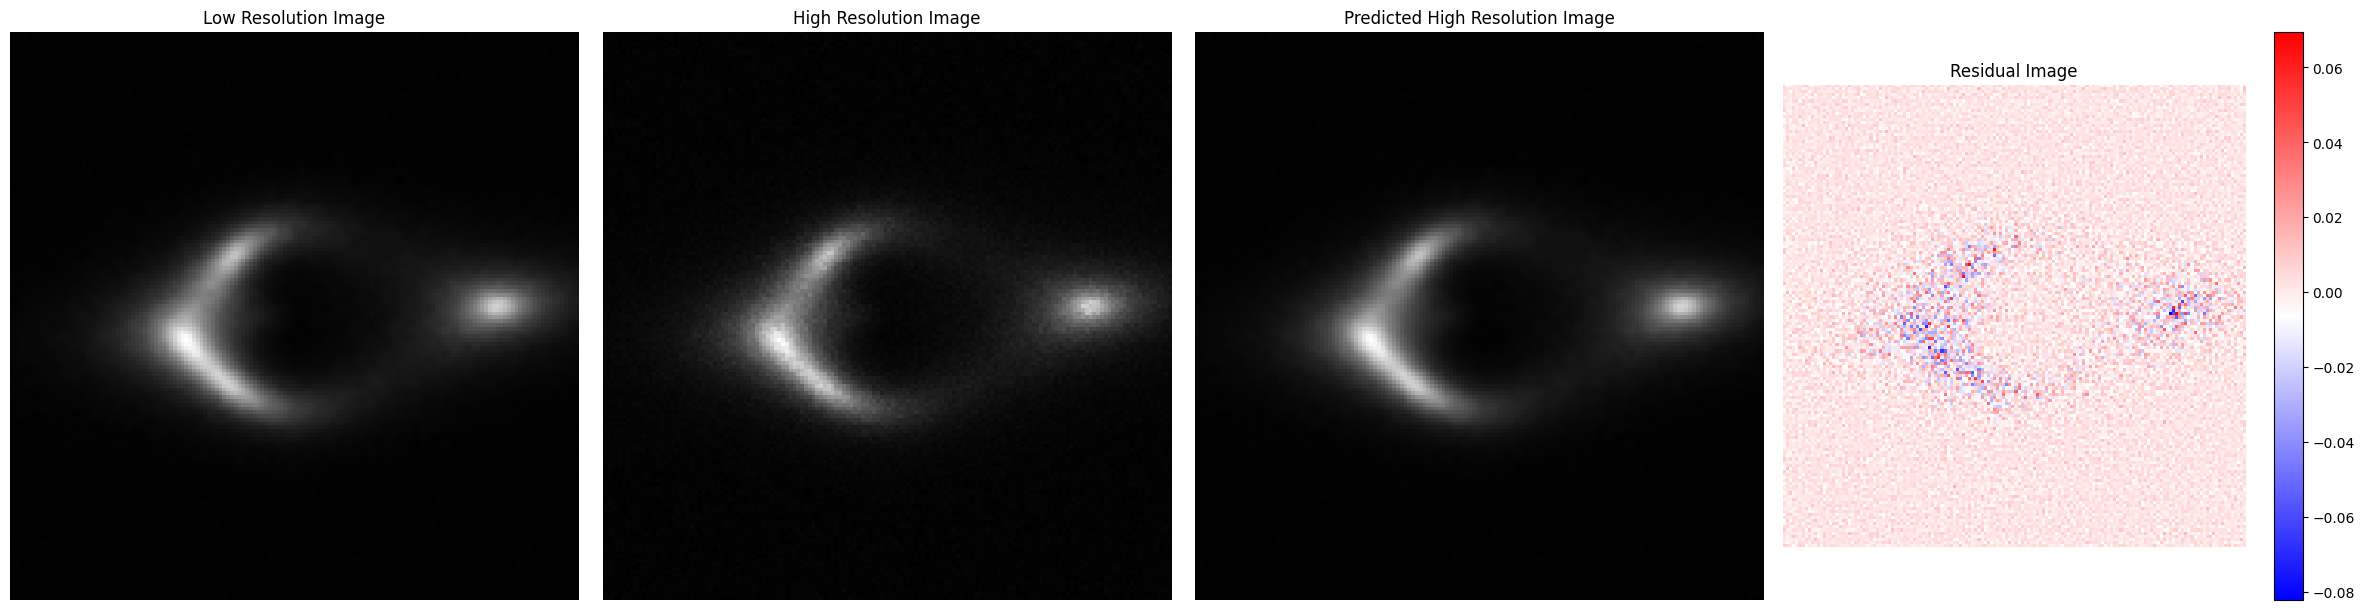

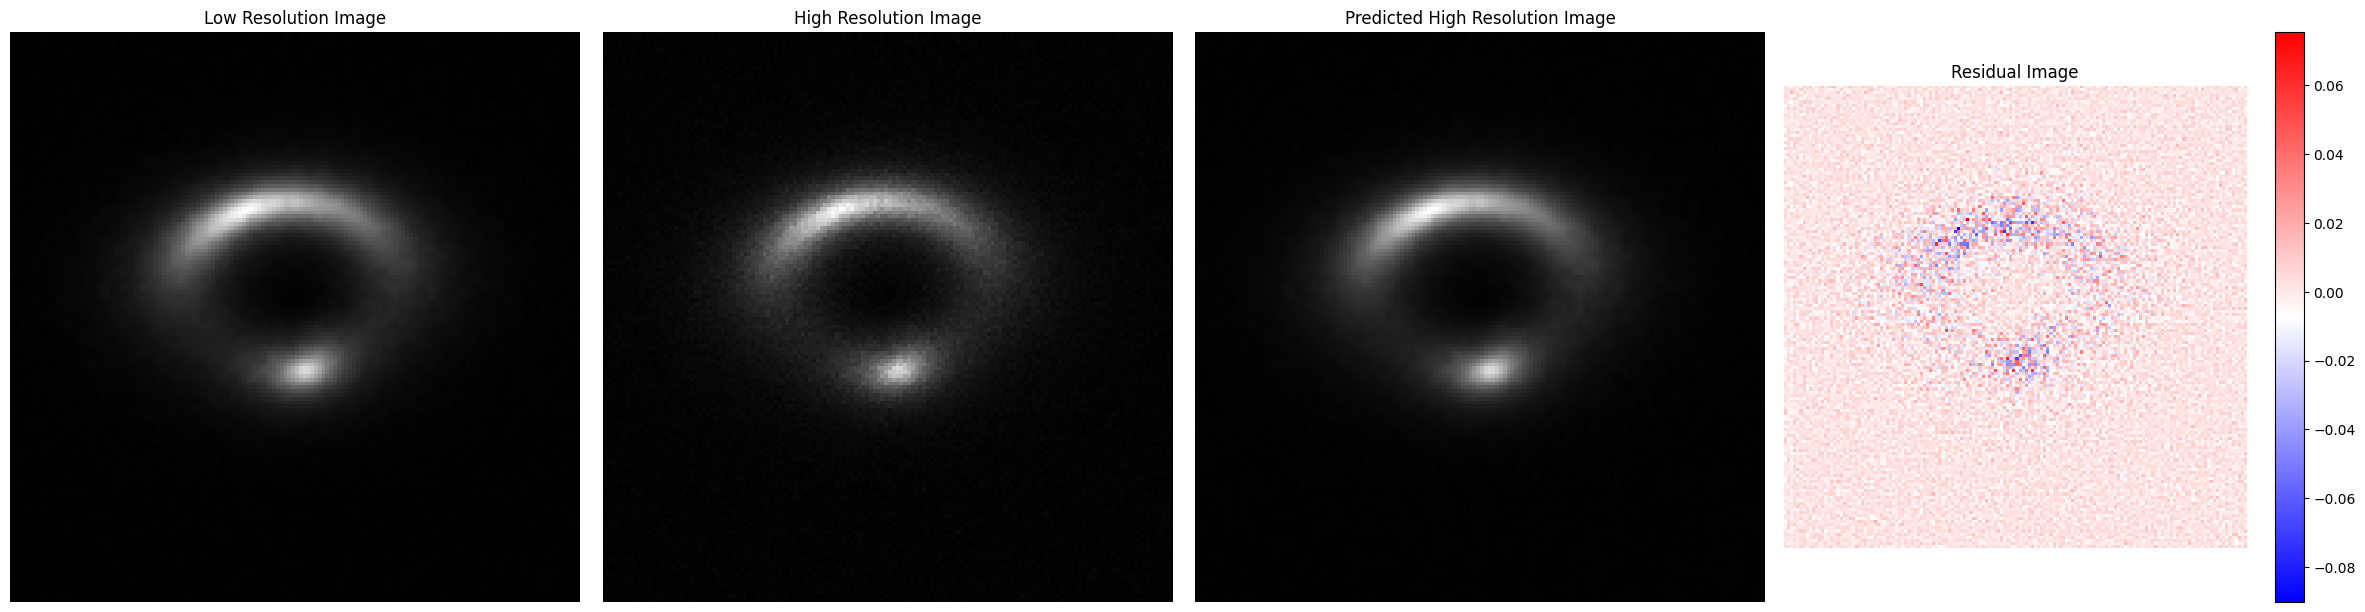

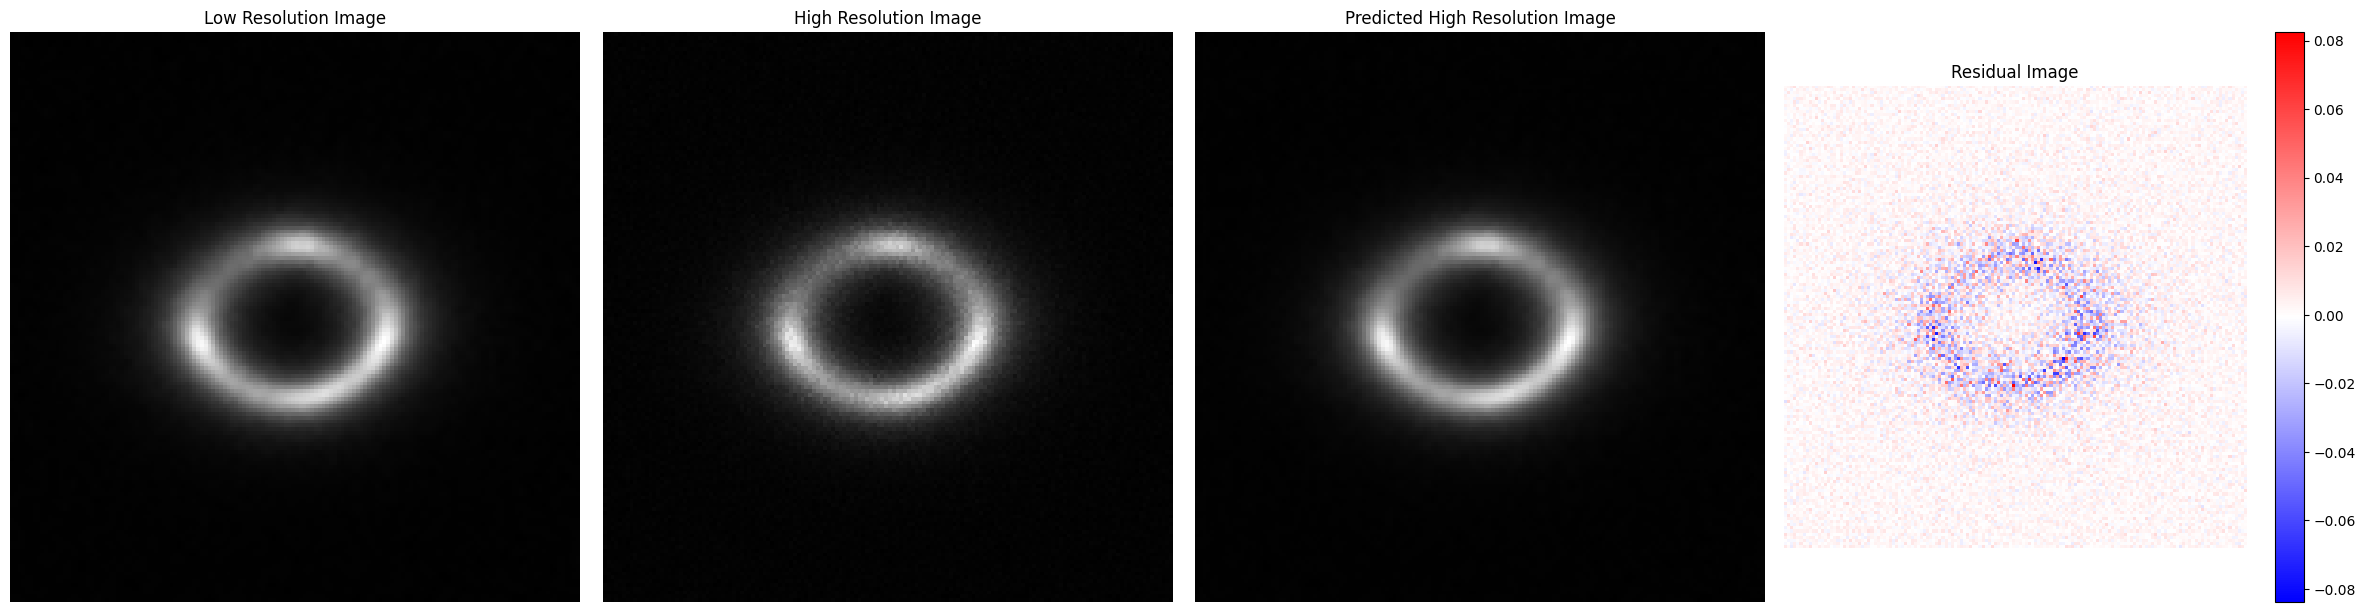

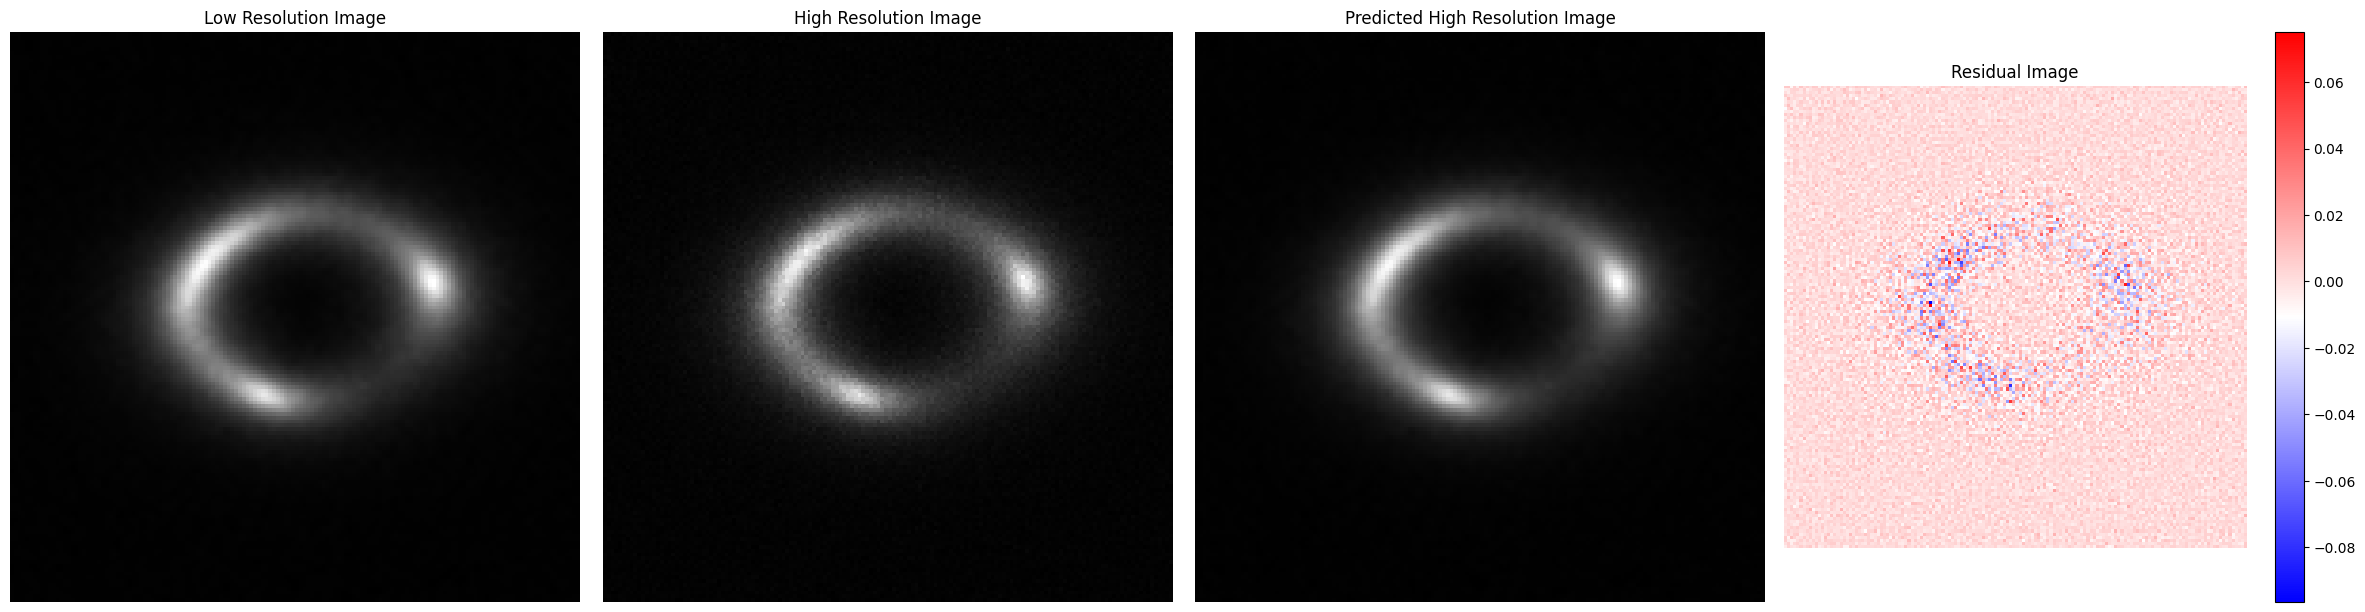

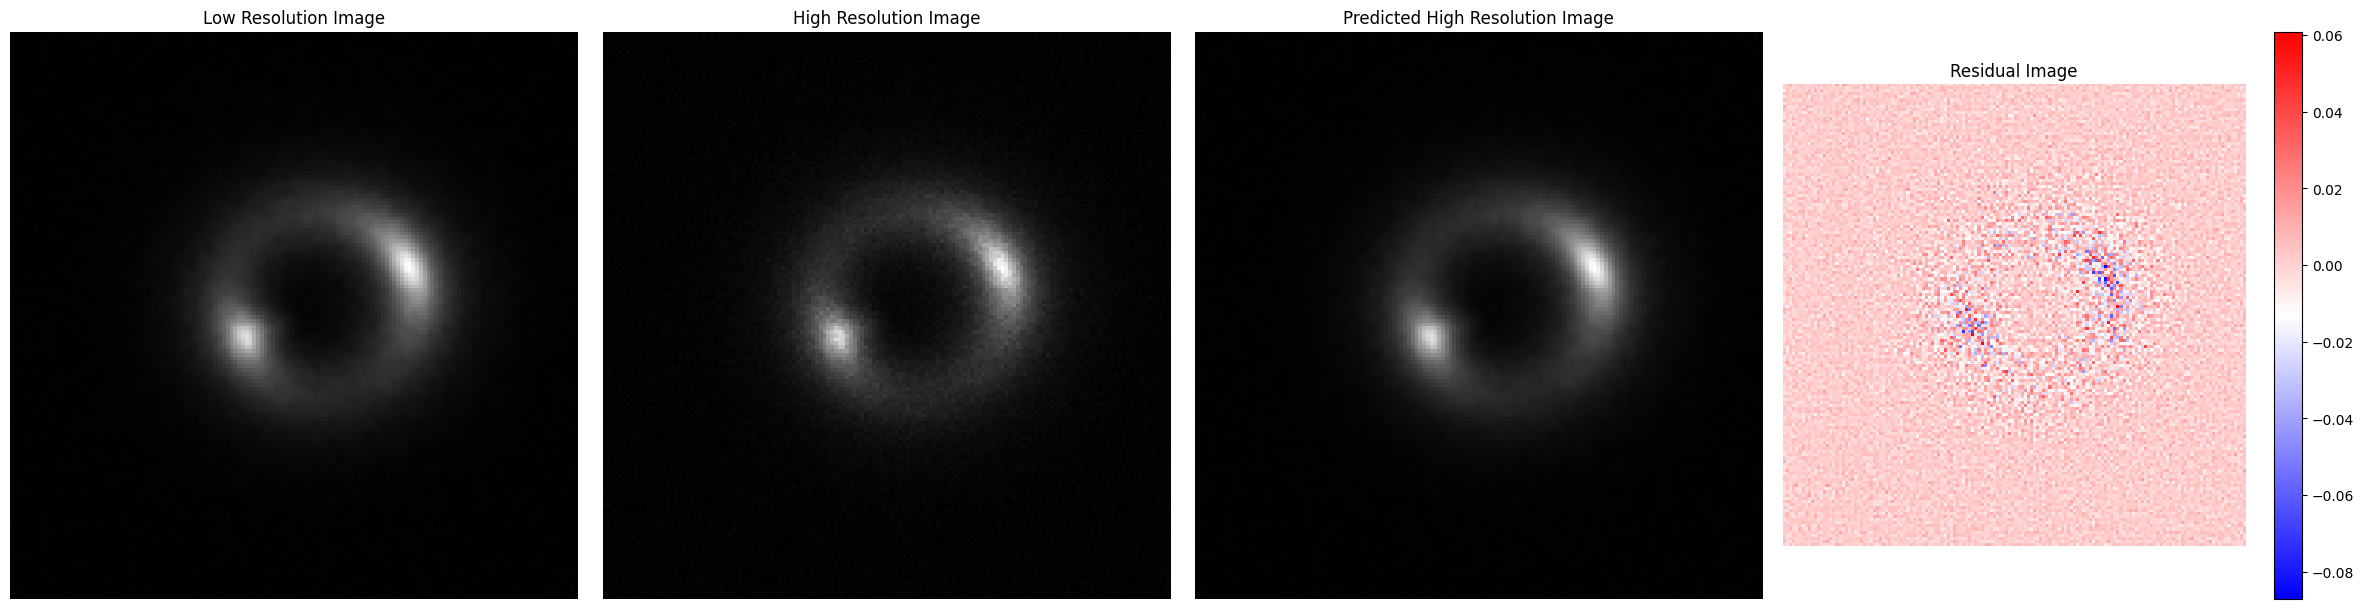

Evaluating:   1%|          | 1/125 [00:02<05:46,  2.80s/it]


In [20]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_diffusion_model(model, test_dataloader, device, num_samples=5):
    model.eval()
    sample_count = 0
    
    with torch.no_grad():
        for i, (lr_batch, hr_batch) in enumerate(tqdm(test_dataloader, desc="Evaluating")):
            if sample_count >= num_samples:
                break
            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
            timesteps = torch.full((lr_batch.size(0),), 1000, device=device).long()
            random_residual = torch.randn_like(lr_batch)
            model_input = torch.cat([lr_batch, random_residual], dim=1)
            pred_hr_residual = model(model_input, timesteps)
            pred_hr_batch = lr_batch + pred_hr_residual
            lr_batch = lr_batch.cpu()
            hr_batch = hr_batch.cpu()
            pred_hr_batch = pred_hr_batch.cpu()
            pred_hr_residual = hr_batch - pred_hr_batch
            for j in range(lr_batch.size(0)):
                if sample_count >= num_samples:
                    break
                
                lr = lr_batch[j].squeeze()
                hr = hr_batch[j].squeeze()
                pred_hr = pred_hr_batch[j].squeeze()
                residual = pred_hr_residual[j].squeeze()
                
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
                
                im1 = ax1.imshow(lr, cmap='gray')
                ax1.set_title('Low Resolution Image')
                ax1.axis('off')
                
                im2 = ax2.imshow(hr, cmap='gray')
                ax2.set_title('High Resolution Image')
                ax2.axis('off')
                
                im3 = ax3.imshow(pred_hr, cmap='gray')
                ax3.set_title('Predicted High Resolution Image')
                ax3.axis('off')
                
                im4 = ax4.imshow(residual, cmap='bwr')
                ax4.set_title('Residual Image')
                ax4.axis('off')
                fig.colorbar(im4, ax=ax4)
                
                plt.tight_layout()
                plt.show()
                
                sample_count += 1

evaluate_diffusion_model(model, test_loader, device, num_samples=5)